In [1]:
import ase
import ase.io
import bokeh
from bokeh.io import show
import functools
import matscipy.neighbours
import numpy as np
import pandas as pd
import pcax
import pymatgen
from pymatgen.core import Lattice, Molecule, Structure
import matplotlib.pyplot as plt
import os
import tqdm
import sys

from analyses.nearest_neighbors import CrystalNN, VoronoiNN
import symphony.models.ptable as ptable
import pyspectra
import pyspectra.spectra
import pyspectra.utils
import pyspectra.visualize

sys.path.append('/home/songk/cmap_periodictable/')
from ptable_trends import ptable_plotter

/tmp/ipykernel_2982964/3986836472.py:8: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd


In [2]:
xyzs_path = "../tmqm_data/tmqm/data/xyz"
mols = []
for mol_file in tqdm.tqdm(os.listdir(xyzs_path)):
    mol_as_ase = ase.io.read(os.path.join(xyzs_path, mol_file), format="xyz")
    if mol_as_ase is None:
        continue
    mols.append(mol_as_ase)

  0%|          | 0/86665 [00:00<?, ?it/s]

100%|██████████| 86665/86665 [00:19<00:00, 4523.59it/s]


bispectra

In [3]:
el = 'Ni'

In [4]:
mols_w_el = []
for mol in tqdm.tqdm(mols):
    if el in mol.get_chemical_symbols():
        struct = Molecule(mol.get_chemical_symbols(), mol.get_positions())
        mols_w_el.append(struct)

100%|██████████| 86665/86665 [00:07<00:00, 11782.30it/s]


In [10]:
def cutoff(mol, site_index, cutoff=2.):
    # min_dist = np.min(np.linalg.norm(
    #     mol.cart_coords[site_index] - mol.cart_coords[np.arange(len(mol)) != site_index],
    #     axis=-1))
    # return mol.get_neighbors(mol[site_index], min_dist + nn_tol)
    return mol.get_neighbors(mol[site_index], cutoff)

def cutoff2(mol, site_index):
    return cutoff(mol, site_index, 3.)

In [11]:
spectra_comp = pyspectra.spectra.Spectra()
spectra_comp.set_cutoff(cutoff)

spectra = []
el_ndxs = []
for mol in tqdm.tqdm(mols_w_el):
    spectra_comp.load_structure(mol)
    bispectrum = spectra_comp.compute_element_spectra(el)
    assert len(bispectrum) == 1
    for ndx in bispectrum:
        spectra.append(bispectrum[ndx])
        el_ndxs.append(ndx)

100%|██████████| 8702/8702 [01:10<00:00, 124.16it/s]


In [8]:
spectra_comp = pyspectra.spectra.Spectra()
spectra_comp.set_cutoff(cutoff2)

spectra2 = []
el_ndxs = []
for mol in tqdm.tqdm(mols_w_el):
    spectra_comp.load_structure(mol)
    bispectrum = spectra_comp.compute_element_spectra(el)
    assert len(bispectrum) == 1
    for ndx in bispectrum:
        spectra2.append(bispectrum[ndx])
        el_ndxs.append(ndx)

100%|██████████| 8702/8702 [01:48<00:00, 80.19it/s] 


In [13]:
mols_w_el[i].to('example.xyz', 'xyz');

In [15]:
nn = VoronoiNN(cutoff=2.3)
i=1
nn.get_voronoi_polyhedra(mols_w_el[i], el_ndxs[i])

[Site: S (15.8644, 4.1219, 8.2709), Site: S (18.4867, 6.5953, 5.6727), Site: S (15.1867, 5.8898, 6.1250), Site: S (19.1721, 4.7828, 7.7788)]


ValueError: No Voronoi neighbors found for site - try increasing cutoff

<Figure size 640x480 with 0 Axes>

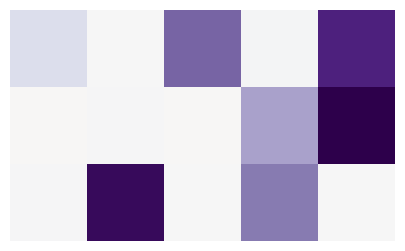

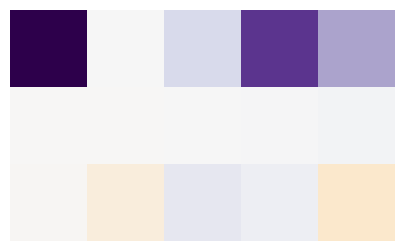

In [15]:
fig = plt.figure()
subfigs = fig.subfigures(1, 2)
i = 20
pyspectra.visualize.colorplot(spectra[i])
pyspectra.visualize.colorplot(spectra2[i])

In [10]:
neighbors = []
for i in tqdm.tqdm(range(len(mols_w_el))):
    neighbors.append(len(cutoff(mols_w_el[i], el_ndxs[i])))

100%|██████████| 8702/8702 [00:02<00:00, 2944.99it/s]


In [11]:
neighbors2 = []
for i in tqdm.tqdm(range(len(mols_w_el))):
    neighbors2.append(len(cutoff2(mols_w_el[i], el_ndxs[i])))

100%|██████████| 8702/8702 [00:03<00:00, 2490.72it/s]


In [12]:
neighbors[0], neighbors2[0]

(4, 11)

In [30]:
min_dists = []
for i in tqdm.tqdm(range(len(mols_w_el))):
    dists = np.linalg.norm(
        mols_w_el[i].cart_coords[el_ndxs[i]] - mols_w_el[i].cart_coords[np.arange(len(mols_w_el[i])) != el_ndxs[i]],
        axis=-1)
    dists = np.asarray(list(set(dists.round(2).tolist())))
    min_dists = min_dists + dists[np.argpartition(dists, 2)[:2]].tolist()

100%|██████████| 8702/8702 [00:01<00:00, 8423.51it/s] 


In [31]:
min_dists[:10]

[1.86, 1.96, 2.22, 2.23, 1.92, 2.07, 1.83, 2.07, 1.84, 1.85]

(array([2.500e+01, 3.200e+01, 1.800e+01, 1.800e+01, 3.100e+01, 1.500e+01,
        9.500e+01, 1.135e+03, 2.776e+03, 2.258e+03, 9.010e+02, 3.500e+02,
        3.280e+02, 2.910e+02, 2.440e+02, 1.290e+02, 5.200e+01, 3.000e+00,
        0.000e+00, 1.000e+00]),
 array([1.36  , 1.4165, 1.473 , 1.5295, 1.586 , 1.6425, 1.699 , 1.7555,
        1.812 , 1.8685, 1.925 , 1.9815, 2.038 , 2.0945, 2.151 , 2.2075,
        2.264 , 2.3205, 2.377 , 2.4335, 2.49  ]),
 <BarContainer object of 20 artists>)

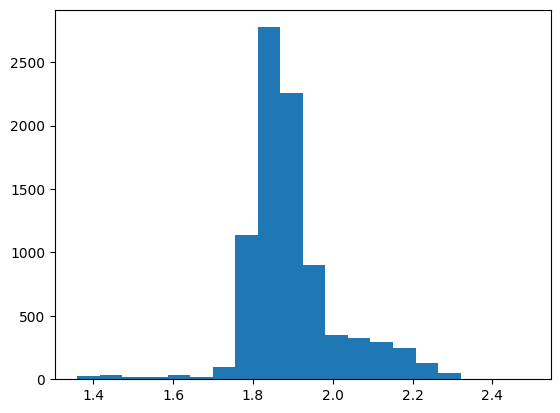

In [29]:
plt.hist(min_dists, bins=20)

In [15]:
set(neighbors)

{2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12}

In [34]:
max_neighbor_ndx = np.argmax(np.array(neighbors))
mols_w_el[max_neighbor_ndx].to('example.xyz', 'xyz');

In [16]:
min_neighbor_ndx = np.argmin(np.array(neighbors))
mols_w_el[min_neighbor_ndx].to('example.xyz', 'xyz');

Text(0.5, 1.0, 'PCA of Ni local environments')

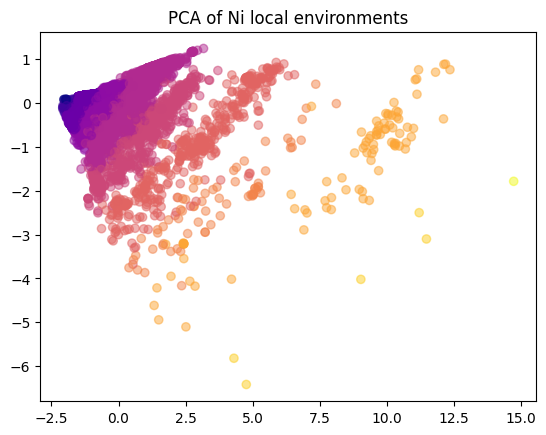

In [17]:
spectra = np.asarray(spectra)
state = pcax.fit(spectra, 2)
X = pcax.transform(state, spectra)
plt.scatter(X[:, 0], X[:, 1], c=neighbors, cmap='plasma', alpha=0.5)
plt.title(f'PCA of {el} local environments')

In [17]:
pyspectra.visualize.visualize_geometry(spectra_comp.invert(spectra[14]))

general stats

In [3]:
# neighbors = [[] for _ in range(18)]
min_dists = [[] for _ in range(18)]
for atoms in tqdm.tqdm(mols):
    senders, receivers = matscipy.neighbours.neighbour_list(
        quantities="ij", positions=atoms.positions, cutoff=3.0#, cell=3*np.eye(3)
    )
    species = atoms.get_atomic_numbers()
    for sender in set(senders):
        min_dist = 1e8
        for receiver in receivers[senders==sender]:
            min_dist = min(min_dist, np.linalg.norm(atoms.positions[sender] - atoms.positions[receiver]))
        min_dists[ptable.groups[species[sender]-1]].append(min_dist)
        # neighbors[ptable.groups[species[sender]-1]].append(len(receivers[senders==sender]))

100%|██████████| 86665/86665 [33:55<00:00, 42.58it/s]


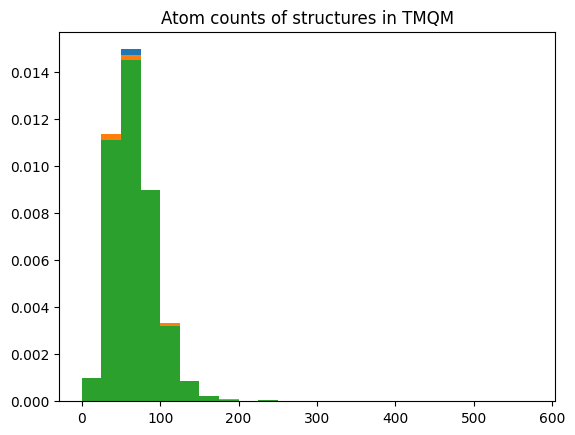

In [8]:
plt.hist([len(mol) for mol in mols], bins=range(0, 600, 25), density=True)
plt.title("Atom counts of structures in TMQM")
plt.show()

In [3]:
element_counts = {}
element_counts_per_mol = {}
for mol in tqdm.tqdm(mols[:10000]):
    e_to_add = set()
    for symbol, num in zip(mol.get_chemical_symbols(), mol.get_atomic_numbers()):
        if ptable.groups[num-1] < 2 or ptable.groups[num-1] > 11: continue
        if symbol not in element_counts:
            element_counts[symbol] = 0
            element_counts_per_mol[symbol] = 0
        element_counts[symbol] += 1
        e_to_add.add(symbol)
    for symbol in e_to_add:
        element_counts_per_mol[symbol] += 1

  0%|          | 0/10000 [00:00<?, ?it/s]

100%|██████████| 10000/10000 [07:38<00:00, 21.82it/s]


In [5]:
element_count_df = pd.DataFrame(columns=["element", "count"], data=[[k, v] for k, v in element_counts.items()])
element_count_df.to_csv("element_counts_10k.csv", index=False, header=False)
fig = ptable_plotter("element_counts_10k.csv", log_scale=False)
bokeh.io.save(fig, 'element_counts_10k.html')

/home/songk/cmap_periodictable/ptable_trends.py:166: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  elements.group[i] = str(count + 4)
/home/songk/cmap_periodictable/ptable_trends.py:166: FutureWarning: ChainedAssignmentError: behaviour will 

'/home/songk/symphony-tmqm/notebooks/element_counts_10k.html'